In [1]:
print('Hello world!')

Hello world!


### Experimental Setting

In [2]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (0,999)
NUM2_RANGE = (0,999)
TRAINING_SAMPLE_SIZE =10000
TEST_SAMPLE_SIZE = 100
TRAINING_EPOCH = 100

### Transformer for Calculation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [7]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-6 #1e-3
EPOCHS = TRAINING_EPOCH

In [8]:
# TODO: delete
n_embd = EMBED_SIZE
block_size = MAX_LEN
n_layer = NUM_LAYERS
dropout = DROPOUT

In [9]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [11]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [14]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(max_len, embed_size)
        self.blocks = nn.Sequential(*[Block(embed_size, n_head=num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_size) # final layer norm
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        return logits


In [15]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png', bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [16]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

e:\arithmeticGPT-simple\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [18]:
model = model.to(device)

In [19]:
PCA_TITLE_PREFIX = "TOP-8 Embedding PCA"

In [20]:
emb_func = model.token_embedding_table

In [21]:
data = emb_func(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:0, Loss:N/A)')

100%|██████████| 10000/10000 [02:48<00:00, 59.46it/s]


Epoch 1, Loss: 1.784134452879429


100%|██████████| 10000/10000 [03:33<00:00, 46.85it/s]


Epoch 2, Loss: 1.7507156111359596


100%|██████████| 10000/10000 [03:53<00:00, 42.87it/s]


Epoch 3, Loss: 1.748005974817276


100%|██████████| 10000/10000 [03:14<00:00, 51.39it/s]


Epoch 4, Loss: 1.7469298564314841


100%|██████████| 10000/10000 [03:17<00:00, 50.52it/s]


Epoch 5, Loss: 1.7462207366347313


100%|██████████| 10000/10000 [03:14<00:00, 51.40it/s]


Epoch 6, Loss: 1.7456130874752998


100%|██████████| 10000/10000 [03:20<00:00, 49.99it/s]


Epoch 7, Loss: 1.7450065529108048


100%|██████████| 10000/10000 [03:12<00:00, 52.03it/s]


Epoch 8, Loss: 1.7443235303878784


100%|██████████| 10000/10000 [03:23<00:00, 49.15it/s]


Epoch 9, Loss: 1.7434484099268914


100%|██████████| 10000/10000 [03:41<00:00, 45.05it/s]


Epoch 10, Loss: 1.742143963265419


100%|██████████| 10000/10000 [03:50<00:00, 43.48it/s]


Epoch 11, Loss: 1.7399068315386772


100%|██████████| 10000/10000 [03:52<00:00, 43.02it/s]


Epoch 12, Loss: 1.735873226606846


100%|██████████| 10000/10000 [03:48<00:00, 43.72it/s]


Epoch 13, Loss: 1.7286134745955468


100%|██████████| 10000/10000 [03:54<00:00, 42.68it/s]


Epoch 14, Loss: 1.7135644323468209


100%|██████████| 10000/10000 [03:49<00:00, 43.53it/s]


Epoch 15, Loss: 1.662113416647911


100%|██████████| 10000/10000 [03:46<00:00, 44.08it/s]


Epoch 16, Loss: 1.5811435099720954


100%|██████████| 10000/10000 [03:52<00:00, 43.01it/s]


Epoch 17, Loss: 1.55469035384655


100%|██████████| 10000/10000 [03:42<00:00, 44.99it/s]


Epoch 18, Loss: 1.5418866793632506


100%|██████████| 10000/10000 [02:39<00:00, 62.58it/s]


Epoch 19, Loss: 1.5300801386594773


100%|██████████| 10000/10000 [02:37<00:00, 63.48it/s]


Epoch 20, Loss: 1.5158753320097924


100%|██████████| 10000/10000 [02:36<00:00, 64.01it/s]


Epoch 21, Loss: 1.4973592595219611


100%|██████████| 10000/10000 [02:35<00:00, 64.41it/s]


Epoch 22, Loss: 1.4739687533974648


100%|██████████| 10000/10000 [02:38<00:00, 63.03it/s]


Epoch 23, Loss: 1.446204818212986


100%|██████████| 10000/10000 [02:34<00:00, 64.86it/s]


Epoch 24, Loss: 1.4146408069610596


100%|██████████| 10000/10000 [02:39<00:00, 62.86it/s]


Epoch 25, Loss: 1.380327007639408


100%|██████████| 10000/10000 [02:34<00:00, 64.56it/s]


Epoch 26, Loss: 1.3462410897254944


100%|██████████| 10000/10000 [02:37<00:00, 63.65it/s]


Epoch 27, Loss: 1.3154439862132072


100%|██████████| 10000/10000 [02:38<00:00, 63.00it/s]


Epoch 28, Loss: 1.2894085415244103


100%|██████████| 10000/10000 [03:44<00:00, 44.60it/s]


Epoch 29, Loss: 1.268329307115078


100%|██████████| 10000/10000 [03:44<00:00, 44.53it/s]


Epoch 30, Loss: 1.2513392454504966


100%|██████████| 10000/10000 [03:45<00:00, 44.38it/s]


Epoch 31, Loss: 1.2372906426548957


100%|██████████| 10000/10000 [03:43<00:00, 44.67it/s]


Epoch 32, Loss: 1.2252002005815505


100%|██████████| 10000/10000 [03:47<00:00, 44.03it/s]


Epoch 33, Loss: 1.2143009650588035


100%|██████████| 10000/10000 [03:43<00:00, 44.78it/s]


Epoch 34, Loss: 1.2040271630883217


100%|██████████| 10000/10000 [03:40<00:00, 45.38it/s]


Epoch 35, Loss: 1.1940524875044822


100%|██████████| 10000/10000 [03:42<00:00, 44.91it/s]


Epoch 36, Loss: 1.1842287245988845


100%|██████████| 10000/10000 [03:01<00:00, 55.09it/s]


Epoch 37, Loss: 1.174467601799965


100%|██████████| 10000/10000 [02:55<00:00, 56.94it/s]


Epoch 38, Loss: 1.1647031869649886


100%|██████████| 10000/10000 [03:15<00:00, 51.06it/s]


Epoch 39, Loss: 1.1548577658653258


100%|██████████| 10000/10000 [03:10<00:00, 52.62it/s]


Epoch 40, Loss: 1.144904821586609


100%|██████████| 10000/10000 [03:34<00:00, 46.62it/s]


Epoch 41, Loss: 1.134944723033905


100%|██████████| 10000/10000 [03:39<00:00, 45.60it/s]


Epoch 42, Loss: 1.1253112665474414


100%|██████████| 10000/10000 [03:44<00:00, 44.48it/s]


Epoch 43, Loss: 1.1164917479217051


100%|██████████| 10000/10000 [03:38<00:00, 45.80it/s]


Epoch 44, Loss: 1.1088597599446774


100%|██████████| 10000/10000 [03:42<00:00, 44.98it/s]


Epoch 45, Loss: 1.1024991414129734


100%|██████████| 10000/10000 [04:17<00:00, 38.88it/s]


Epoch 46, Loss: 1.0972647211551667


100%|██████████| 10000/10000 [04:15<00:00, 39.08it/s]


Epoch 47, Loss: 1.0929297555744648


100%|██████████| 10000/10000 [04:17<00:00, 38.86it/s]


Epoch 48, Loss: 1.0892798068642617


100%|██████████| 10000/10000 [04:16<00:00, 38.97it/s]


Epoch 49, Loss: 1.0861614340424537


100%|██████████| 10000/10000 [04:18<00:00, 38.62it/s]


Epoch 50, Loss: 1.0834904191970824


100%|██████████| 10000/10000 [04:16<00:00, 38.93it/s]


Epoch 51, Loss: 1.0812008746802806


100%|██████████| 10000/10000 [04:18<00:00, 38.69it/s]


Epoch 52, Loss: 1.0792415776371955


100%|██████████| 10000/10000 [04:09<00:00, 40.06it/s]


Epoch 53, Loss: 1.0775618271946907


100%|██████████| 10000/10000 [02:33<00:00, 65.09it/s]


Epoch 54, Loss: 1.07612982391119


100%|██████████| 10000/10000 [02:37<00:00, 63.45it/s]


Epoch 55, Loss: 1.0749140394806862


100%|██████████| 10000/10000 [02:34<00:00, 64.83it/s]


Epoch 56, Loss: 1.0738851094543933


100%|██████████| 10000/10000 [02:36<00:00, 63.93it/s]


Epoch 57, Loss: 1.073018935573101


100%|██████████| 10000/10000 [02:35<00:00, 64.52it/s]


Epoch 58, Loss: 1.0722983798742294


100%|██████████| 10000/10000 [02:33<00:00, 64.98it/s]


Epoch 59, Loss: 1.0717056278407573


100%|██████████| 10000/10000 [02:38<00:00, 63.09it/s]


Epoch 60, Loss: 1.0712326110899448


100%|██████████| 10000/10000 [02:33<00:00, 65.15it/s]


Epoch 61, Loss: 1.0708610852181912


100%|██████████| 10000/10000 [02:38<00:00, 62.91it/s]


Epoch 62, Loss: 1.0705723893404007


100%|██████████| 10000/10000 [03:07<00:00, 53.36it/s]


Epoch 63, Loss: 1.0703510588169098


100%|██████████| 10000/10000 [04:05<00:00, 40.72it/s]


Epoch 64, Loss: 1.0701824509322644


100%|██████████| 10000/10000 [04:07<00:00, 40.33it/s]


Epoch 65, Loss: 1.0700557246685027


100%|██████████| 10000/10000 [03:58<00:00, 41.92it/s]


Epoch 66, Loss: 1.069961785596609


100%|██████████| 10000/10000 [03:56<00:00, 42.25it/s]


Epoch 67, Loss: 1.069892962962389


100%|██████████| 10000/10000 [04:04<00:00, 40.83it/s]


Epoch 68, Loss: 1.0698433605015278


100%|██████████| 10000/10000 [03:56<00:00, 42.36it/s]


Epoch 69, Loss: 1.0698082431793212


100%|██████████| 10000/10000 [03:57<00:00, 42.12it/s]


Epoch 70, Loss: 1.0697836923718453


100%|██████████| 10000/10000 [03:57<00:00, 42.05it/s]


Epoch 71, Loss: 1.0697668787121772


100%|██████████| 10000/10000 [04:02<00:00, 41.22it/s]


Epoch 72, Loss: 1.0697556123614311


100%|██████████| 10000/10000 [04:07<00:00, 40.48it/s]


Epoch 73, Loss: 1.0697481905281543


100%|██████████| 10000/10000 [04:15<00:00, 39.17it/s]


Epoch 74, Loss: 1.0697434236705303


100%|██████████| 10000/10000 [04:18<00:00, 38.67it/s]


Epoch 75, Loss: 1.0697404144108296


100%|██████████| 10000/10000 [04:05<00:00, 40.68it/s]


Epoch 76, Loss: 1.0697385527551173


100%|██████████| 10000/10000 [04:03<00:00, 41.11it/s]


Epoch 77, Loss: 1.0697374215841293


100%|██████████| 10000/10000 [03:01<00:00, 55.01it/s]


Epoch 78, Loss: 1.0697367523908614


100%|██████████| 10000/10000 [02:37<00:00, 63.32it/s]


Epoch 79, Loss: 1.0697363703846932


100%|██████████| 10000/10000 [02:38<00:00, 62.96it/s]


Epoch 80, Loss: 1.0697361611127854


100%|██████████| 10000/10000 [02:36<00:00, 63.72it/s]


Epoch 81, Loss: 1.0697360473275184


100%|██████████| 10000/10000 [02:36<00:00, 64.00it/s]


Epoch 82, Loss: 1.0697359851360322


100%|██████████| 10000/10000 [02:37<00:00, 63.51it/s]


Epoch 83, Loss: 1.0697359519779681


100%|██████████| 10000/10000 [02:38<00:00, 63.29it/s]


Epoch 84, Loss: 1.0697359340548516


100%|██████████| 10000/10000 [02:35<00:00, 64.34it/s]


Epoch 85, Loss: 1.0697359245836735


100%|██████████| 10000/10000 [02:41<00:00, 61.78it/s]


Epoch 86, Loss: 1.0697359192371367


100%|██████████| 10000/10000 [02:34<00:00, 64.59it/s]


Epoch 87, Loss: 1.0697359166264535


100%|██████████| 10000/10000 [02:38<00:00, 63.26it/s]


Epoch 88, Loss: 1.0697359154760837


100%|██████████| 10000/10000 [02:36<00:00, 63.92it/s]


Epoch 89, Loss: 1.0697359147429466


100%|██████████| 10000/10000 [02:35<00:00, 64.38it/s]


Epoch 90, Loss: 1.0697359142661094


100%|██████████| 10000/10000 [02:35<00:00, 64.36it/s]


Epoch 91, Loss: 1.0697359140098095


100%|██████████| 10000/10000 [02:35<00:00, 64.29it/s]


Epoch 92, Loss: 1.0697359137952327


100%|██████████| 10000/10000 [02:40<00:00, 62.46it/s]


Epoch 93, Loss: 1.0697359137237072


100%|██████████| 10000/10000 [02:34<00:00, 64.83it/s]


Epoch 94, Loss: 1.0697359136879445


100%|██████████| 10000/10000 [02:38<00:00, 63.19it/s]


Epoch 95, Loss: 1.069735913592577


100%|██████████| 10000/10000 [02:35<00:00, 64.40it/s]


Epoch 96, Loss: 1.0697359135568143


100%|██████████| 10000/10000 [02:38<00:00, 63.16it/s]


Epoch 97, Loss: 1.0697359135329723


100%|██████████| 10000/10000 [02:36<00:00, 63.86it/s]


Epoch 98, Loss: 1.0697359135329723


100%|██████████| 10000/10000 [02:36<00:00, 63.95it/s]


Epoch 99, Loss: 1.0697359135210514


100%|██████████| 10000/10000 [02:36<00:00, 63.86it/s]


Epoch 100, Loss: 1.0697359135091304


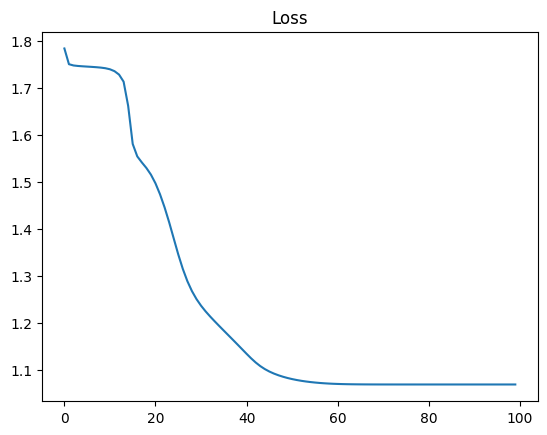

In [22]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = emb_func(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

In [23]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  822+147=969
target_char:  ['9', '6', '9']
output_char:  ['9', '6', '9']
sentence:  46+883=254
target_char:  ['2', '5', '4']
output_char:  ['2', '5', '4']
sentence:  516+629=1451
target_char:  ['1', '4', '5', '1']
output_char:  ['1', '4', '5', '1']
sentence:  894+645=4401
target_char:  ['4', '4', '0', '1']
output_char:  ['4', '4', '0', '1']
sentence:  296+203=499
target_char:  ['4', '9', '9']
output_char:  ['4', '9', '9']
sentence:  9+826=736
target_char:  ['7', '3', '6']
output_char:  ['7', '3', '6']
sentence:  186+479=5561
target_char:  ['5', '5', '6', '1']
output_char:  ['5', '5', '6', '1']
sentence:  705+421=136
target_char:  ['1', '3', '6']
output_char:  ['1', '3', '6']
sentence:  583+8=393
target_char:  ['3', '9', '3']
output_char:  ['3', '9', '3']
sentence:  338+475=7041
target_char:  ['7', '0', '4', '1']
output_char:  ['7', '0', '4', '1']
sentence:  349+32=669
target_char:  ['6', '6', '9']
output_char:  ['6', '6', '9']
sentence:  338+693=9221
target_char:  ['9', '2', 

In [24]:
print("Accuracy: ", accuracy)

Accuracy:  1.0


In [25]:
# Write experimental results
if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{TRAINING_EPOCH}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

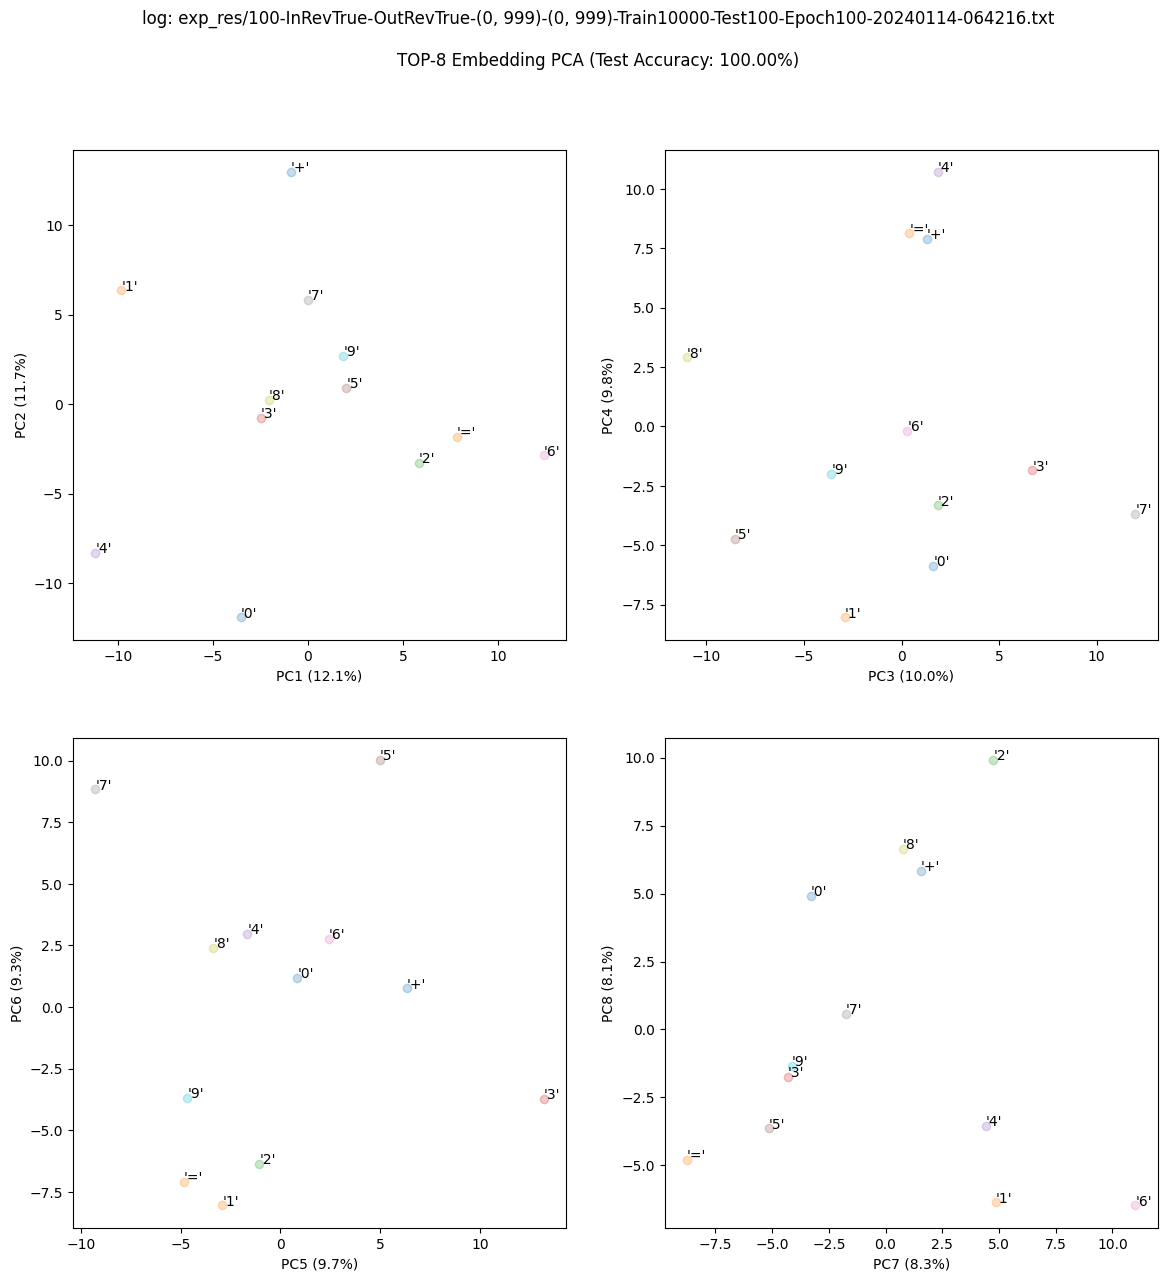

In [26]:
vis_pca(data, TOKENS, title=f'log: {filename}\n\n{PCA_TITLE_PREFIX} (Test Accuracy: {accuracy*100:.2f}%)', show=True)